In [9]:
import pandas as pd

dataset_path = "/mnt/sda/github_issues/github-issues-transformers.jsonl"
df_issues = pd.read_json(dataset_path, lines = True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [10]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [11]:
# We only care about the name field of each label object. So lets overwrite that column

df_issues["labels"] = (df_issues["labels"].apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [12]:
# Now lets aggregate and count the number of labels per issues
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [13]:
# You can see that majority of issues has zero labels. Lets find the most frequent label names. Panda has a explode command that is useful for that purpose
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-10 label categories
df_counts.to_frame().head(10).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
labels,2284,649,106,98,64,52,50,46,42,41


In [14]:
# To make the problem more tractable, lets work with a subset of labels.
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [15]:
# Now look at the distribution of the labels we will be working with
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [16]:
# Later we will find it useful to treat the unlabeled issues as a separate training split. So lets create a new column that
# indicates whether the issue is labeled or not
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [17]:
# Now lets take a look at one example
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [18]:
# The title field looks very useful for our model. Lets add that
df_issues["text"] = (df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis = 1))

In [19]:
# Also remove duplicates
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


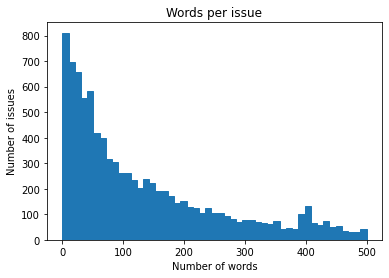

In [20]:
# Its always a good practice to look into number of words per text to make sure the model can handle it.
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

In [21]:
# Its always tricky to create balanced splits when dealing with multilabeled datasets. Lets try a small example first
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [22]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [23]:
# Using the balanced_split(), we can split into supervised and unsupervised datasets, and then create balanced training, validation, and test for the supervised part
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [24]:
# Finally create the dataset dict we will be using throughout
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [25]:
# In this notebook, we will try things from very few to more labels. So lets create sizes of 8, 16, 32,....
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))
        
# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [26]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [27]:
# Lates create a naive baseline. No transformer, just good old Naive Bayes classifier. The algo does not provide multilabel classification out of the box
# But we can model it as a one vs rest problem. For that, we need to create a label_id column
#hide_output
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [28]:
# Lets define two scores:
# 1. Micro: Measures frequent labels only
# 2. Macro: All labels
# We also need dicts as we will try out multiple sizes.
from collections import defaultdict
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [29]:
# Finally its time to train our baseline.
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [30]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, 
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, 
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

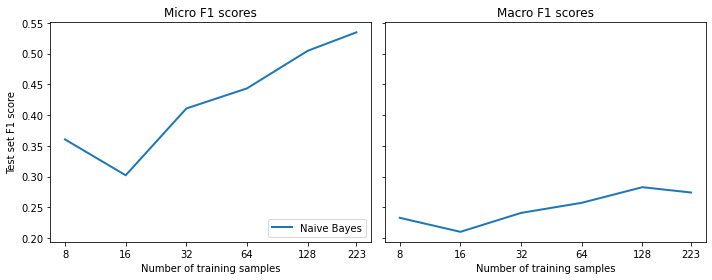

In [31]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

In [35]:
# This was a good baseline to start with. But ultimately, we want transformers.
# The first approach is zero labeled data - aka zero shot classifier. We will use an interesting appraoch to predict masked token.
#hide_output
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# Lets try a fun example about movies.
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [38]:
# instead of blind predicting, we can also query for the probability of a few given tokens.
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


In [40]:
# What if we describe in a way that is more closer to cars. It will still work very well.
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


In [41]:
# This was fun but we can do better using an NLI trick where the model was trained to score relationships between premise and hypothesis. The three relations are:
# 1. Neutral
# 2. Contradiction
# 3. Entailment

from transformers import pipeline
pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [43]:
# Now we can just pass a few labels and see how the model predicts. We also pass multi-label=True since we want to get scores of all labels. 
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [44]:
# We get a good score for new model but other labels are also highly scored. This can happen since the training corpus of the model was very different from code.
# Now lets write a function for a single example and we will pass it through the entire test set
# hide_output
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/transformers/pipelines/base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [45]:
# We now have our scores. But which set of labels we should output? There are two ways:
# 1. Threshold
# 2. pick top k
# To help us choose, lets write a function
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [46]:
# Lets write another function that returns the scikit-learn classification report from a dataset with the predicted labels.
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
        output_dict=True)

In [47]:
# Using these two functions, lets start with the top-k method by increasing k for several values and then plotting micro and macro scores across the validation set.
#hide_output
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

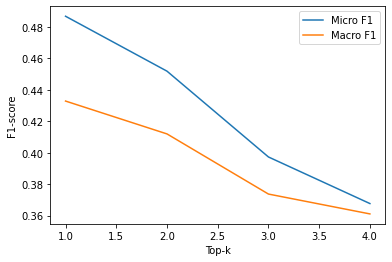

In [48]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [49]:
# It makes sense that top-1 gives the best score because most of our dataset has only 1 label. Now lets compare this against setting a threshold, so that we
# can potentially predict more than one label per example.
#hide_output
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

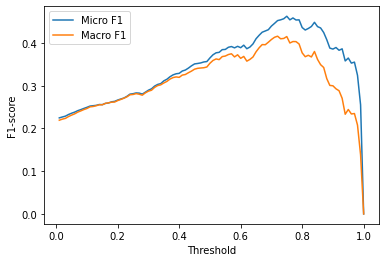

In [50]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [51]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


In [52]:
# Setting a threshold is performing worse than top-1 result, but you can see the precision/recall trade-off from the graph.
# Now lets compare this zero-shot-classification appraoch with our naive bayes one.
#hide_output
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

  0%|          | 0/111 [00:00<?, ?ex/s]

/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/transformers/pipelines/base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/111 [00:00<?, ?ex/s]

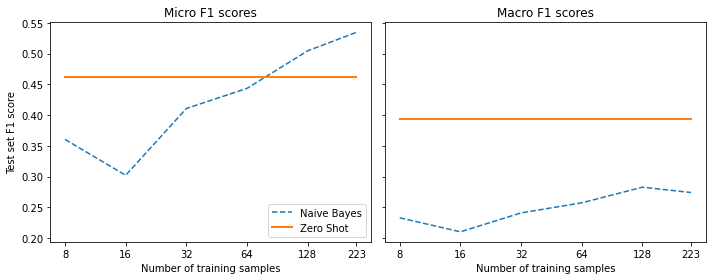

In [53]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

In [54]:
# As we can see, with no labels, The zero shot approach works better than Naive Bayes.
# Now lets work with samples where we have few labels.
# At first we will use data-augmentation technique to increase the number of training samples. There are two ways (translation and synonym replacement)
# to do it an we choose the later.

#hide
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"Original text: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tanvir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/tanvir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tanvir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: Even if you vote down me Megatron, others will turn out to defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: even if you defeat me megatron, others will rise to silently defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: Even if you defeat Megatron me, others to will rise defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: Even if me Megatron, will rise to tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

In [55]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: transformers have the most available toys


In [56]:
# Now lets wrap the augmenter in a function and apply on all samples. Then we can see how it improves our Naive Bayes classifier. As we will see, the performance
# of our Naive Bayes classifier will be improved.
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)]
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

# HOWEVER, WE will not measure or plot Naive Bayes + Aug since we are getting dimenstions error

In [32]:
# Now we will do a very faimilar trick. We will create a cluster of issue embeddings and perform a nearest neighbor search of new issue.
# To create the embedding, we will use GPT-2 model since its the most diverse in terms of handling diverse corpus of texts. Since GPT-2
# creates a token per word, we need mean pooling as well (where the output is available as an eos token). Also GPT-2 does not have padding tokens
# so we will use the eos token.
# Now lets wrap everything in a function and perform embedding!

import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# hide_output
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [34]:
# Now that our embeddings are ready, we need to perform search. Our good friend FAISS will help now.
# Good news is our dataset object has built in support for FAISS indexing.

# We will be using add_faiss_index() function but remember we can also load external embeddings using add_faiss_index_from_external_array()

# hide_output
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Done


In [57]:
# Now we will calculate nearest neighbor based on a great utility function.
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
SCORE: 60.12
LABELS: ['new model']


In [58]:
# This is working pretty great but whats the right value for k (number of nearest neighbors)? Also how many labels (m) we should choose? For example, should we choose
# 3 documents (k = 3) and assign all labels that happens at least twice (m = 2)? Lets try several values of k and for each k, go through m where m < k.

def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [59]:
# Lets calculate the result and also plot them.
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

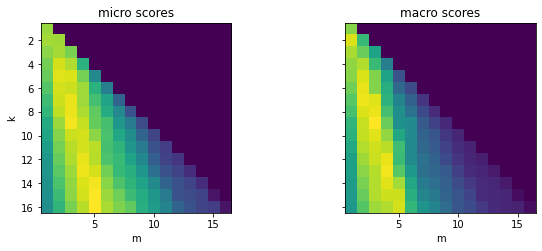

In [60]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [61]:
# From the result, we can see that best ratio of k/m is about 1/3. Lets unravel the mystry plot
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


In [62]:
# Lets plot again after removing the FAISS index since the index cannot be splitted.
# hide_output
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice 
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

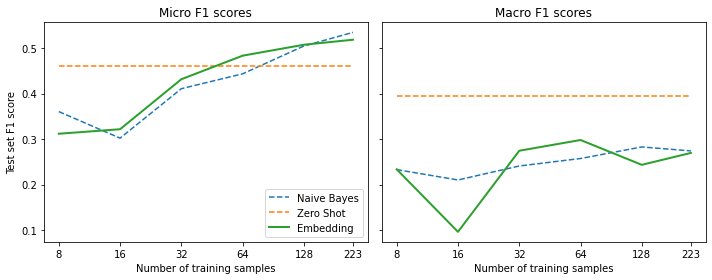

In [63]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

In [64]:
# Going to a different direction. we can also try to fine-tune a pretrained model.
# Lets use standard vanilla BERT as a starting point.

#hide_output
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)
                          
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [65]:
# The multilabel loss function expects labels to be float, since it also allows for class probabilities instead of discrete labels. Lets change
# the type of the column label_ids.

#hide_output
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

  0%|          | 0/223 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/111 [00:00<?, ?ex/s]

  0%|          | 0/9303 [00:00<?, ?ex/s]

In [66]:
# We don;t have many training data so we will likely overfit. We set load_best_model_at_end = True and choose the best model based on micro F1-score.
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0, 
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

In [67]:
# We need F1 score to choose the best model
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [68]:
# We are ready now. For each training set slice we train the classifier from scratch, load the best model at the end of the loop, and store
# the result on the test set

#hide_output
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [ ]:
# hide_output
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

print('Done')

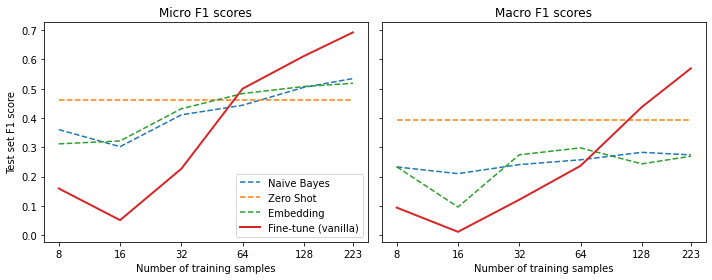

In [70]:
# Finally we plot
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

In [71]:
# Now the final part. What if we have a lot of unlabeled data in addition to few labeled data? The answer is domain adaptation.
# The idea is - Instead of training from sctrach, we continue training a pretrained model on data from our domain. In this step,
# we use the classic language objective of predicting masked word which means we don't need any labeled data. After that, we can load the
# adapted model as a classifier and fine-tune it, thus leveraging the unlabeled data.

# Now we fine-tune the pretrained BERT model with masked language model on the unlabeled portion of our dataset. We only need two extra steps:
# A tokenizer
# A special data collator

#hide_output
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [73]:
# Data collator part
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
# Lets see the collator in action
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
    "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

In [75]:
data_collator.return_tensors = "pt"

In [76]:
# Now we are ready to fine tune the masked language model
#hide_output
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Cloning https://huggingface.co/tanviraumi/bert-base-uncased-issues-128 into local empty directory.
/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or se

{'loss': 2.3389, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.7400484085083008, 'eval_runtime': 0.9844, 'eval_samples_per_second': 226.523, 'eval_steps_per_second': 7.111, 'epoch': 1.0}
{'loss': 1.8014, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.4690239429473877, 'eval_runtime': 0.9838, 'eval_samples_per_second': 226.674, 'eval_steps_per_second': 7.115, 'epoch': 2.0}
{'loss': 1.634, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.4782633781433105, 'eval_runtime': 0.9863, 'eval_samples_per_second': 226.109, 'eval_steps_per_second': 7.098, 'epoch': 3.0}
{'loss': 1.5461, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.391172170639038, 'eval_runtime': 0.9906, 'eval_samples_per_second': 225.12, 'eval_steps_per_second': 7.067, 'epoch': 4.0}
{'loss': 1.4706, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.3108898401260376, 'eval_runtime': 0.9903, 'eval_samples_per_second': 225.189, 'eval_steps_per_second': 7

TrainOutput(global_step=1168, training_loss=1.4345887262527257, metrics={'train_runtime': 844.837, 'train_samples_per_second': 176.185, 'train_steps_per_second': 1.383, 'train_loss': 1.4345887262527257, 'epoch': 16.0})

In [77]:
# hide_output
trainer.push_to_hub("Training complete!")

Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.11k/3.11k [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/tanviraumi/bert-base-uncased-issues-128
   c1f18cc..858a98e  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/tanviraumi/bert-base-uncased-issues-128
   858a98e..e686a50  main -> main



'https://huggingface.co/tanviraumi/bert-base-uncased-issues-128/commit/858a98e1aa5b097f91a07043f2d82a2a46de0715'

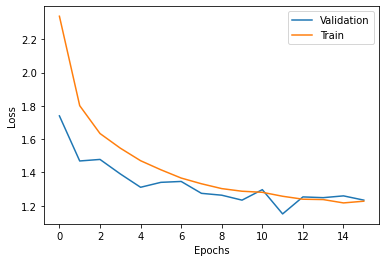

In [78]:
# We can also plot the history of training.
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# We can now fine tune the classifier, but with a slight tweak that we load from our own custom checkpoint
#hide_output
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

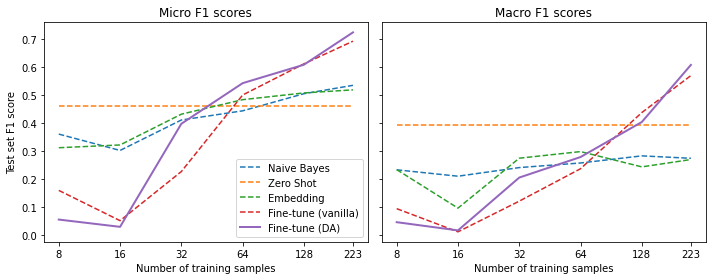

In [80]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")